## Generated images for K=1

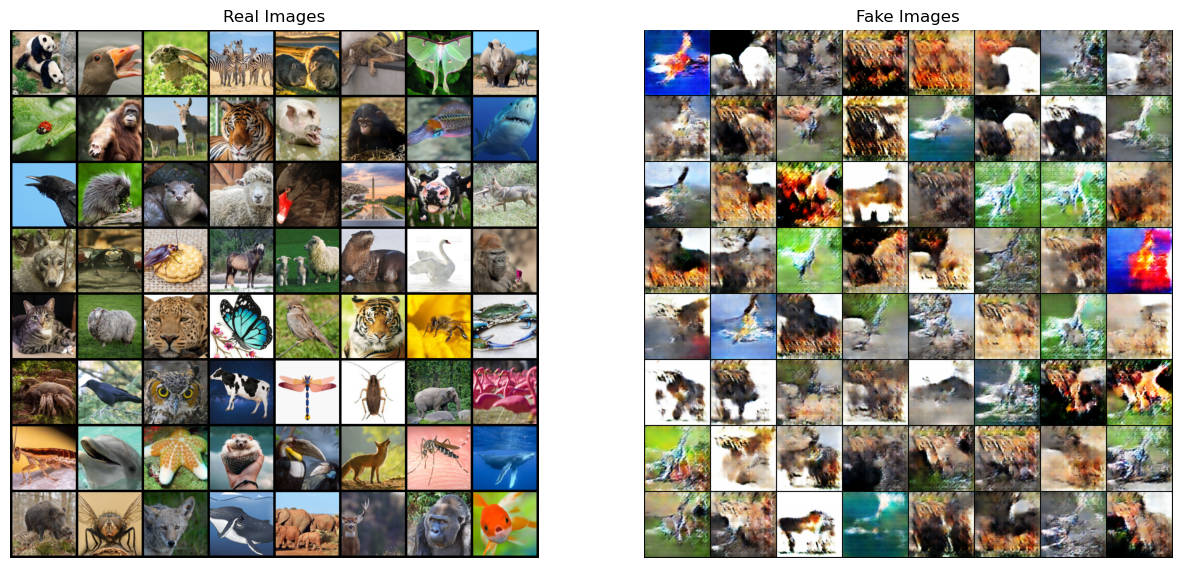

## Generated images for K=5

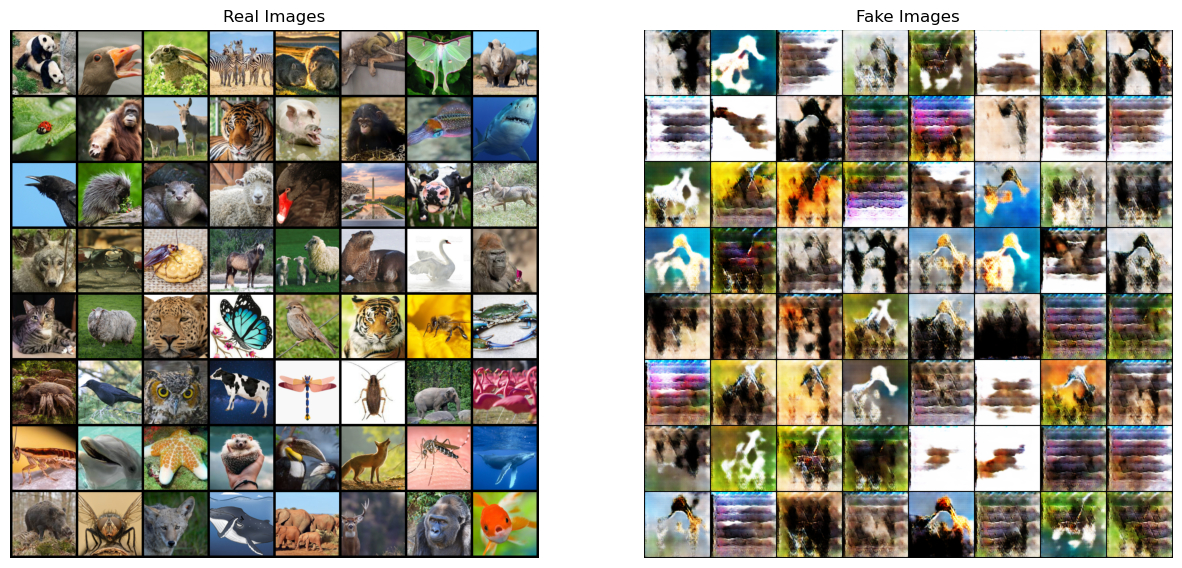

In [ ]:
## FID post training for 1000 samples

import torchvision.utils as vutils

# Function to calculate FID after sampling 1000 images from real and fake data distributions
def calculate_fid_sample(dataloader, netG, num_samples=1000):
    real_images_list = []
    fake_images_list = []
    
    # Collect real images
    for i, data in enumerate(dataloader, 0):
        real_images = data[0].to(device)
        real_images_list.append(real_images)
        if len(real_images_list) * real_images.size(0) >= num_samples:
            break
    
    # Sample fake images
    for _ in range(num_samples // fixed_noise.size(0)):
        with torch.no_grad():
            fake_images = netG(fixed_noise).detach().to(device)
        fake_images_list.append(fake_images)
    
    # Stack images
    real_images = torch.cat(real_images_list[:num_samples], dim=0)[:num_samples]
    fake_images = torch.cat(fake_images_list[:num_samples], dim=0)[:num_samples]
    
    # Calculate FID using 1000 real and fake images
    fid_value = calculate_fid(real_images, fake_images)
    return fid_value

# At the end of each epoch or after training
with torch.no_grad():
    # Sampling 1000 real and fake images
    fid_value = calculate_fid_sample(dataloader, netG, num_samples=1000)
    print(f'FID for 1000 samples after training: {fid_value:.4f}')


## FID for DC-GAN
For K=1, FID : 429.3
For K=5, FID : 430.13



# Training for W-GAN

In [ ]:
# Training Loop for WGAN
torch.use_deterministic_algorithms(False)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
fid_scores = []
iters = 0

# Function to save checkpoints
def save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, fid_scores, iters, path='./checkpoint_wgan_animals_nogp100.pth'):
    state = {
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'fid_scores': fid_scores,
        'iters': iters
    }
    torch.save(state, path)
    print(f'Checkpoint saved at epoch {epoch}, iteration {iters}')

# Function to load checkpoints
def load_checkpoint(netG, netD, optimizerG, optimizerD, path='./checkpoint_wgan_animals_nogp100.pth'):
    if os.path.exists(path):
        state = torch.load(path)
        netG.load_state_dict(state['netG_state_dict'])
        netD.load_state_dict(state['netD_state_dict'])
        optimizerG.load_state_dict(state['optimizerG_state_dict'])
        optimizerD.load_state_dict(state['optimizerD_state_dict'])
        epoch = state['epoch']
        G_losses = state['G_losses']
        D_losses = state['D_losses']
        fid_scores = state['fid_scores']
        iters = state['iters']
        print(f'Checkpoint loaded from epoch {epoch}, iteration {iters}')
        return epoch, G_losses, D_losses, fid_scores, iters
    else:
        print('No checkpoint found, starting from scratch.')
        return 0, [], [], [], 0  # Start from epoch 0 if no checkpoint is found

# Load the latest checkpoint (if available)
start_epoch, G_losses, D_losses, fid_scores, iters = load_checkpoint(netG, netD, optimizerG, optimizerD)

print("Starting Training Loop...")
# For each epoch
for epoch in range(start_epoch,num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D (Critic) network
        ############################
        for _ in range(5):  # Update the critic more times than the generator
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

            # Forward pass real batch through D
            output = netD(real_cpu).view(b_size)  # Get critic scores for real images
            errD_real = output.mean()  # Loss for real images

            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            output = netD(fake.detach()).view(b_size)  # Get critic scores for fake images
            errD_fake = output.mean()  # Loss for fake images

            # Compute error of D as the difference
            errD = errD_fake - errD_real
            # Calculate gradients for D in backward pass
            errD.backward()

            # Update D (Critic)
            optimizerD.step()

            # Clip weights of the critic
            for p in netD.parameters():
                p.data.clamp_(-0.01, 0.01)

            D_losses.append(errD.item())

        ############################
        # (2) Update G network
        ############################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)  # Get critic scores for fake images
        errG = -output.mean()  # Negative mean for generator loss
        errG.backward()
        
        # Update G
        optimizerG.step()
        G_losses.append(errG.item())
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader), 
                     errD.item(), errG.item()))
        
        # Save G's output on fixed_noise for evaluation
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

    # Calculate FID after each epoch
    with torch.no_grad():
        real_images = next(iter(dataloader))[0][:64]  # Adjust as necessary
        fake_images = netG(fixed_noise).detach()  # Use fixed_noise for consistency
        fid_value = calculate_fid(real_images, fake_images)
        fid_scores.append(fid_value)
        print(f'Epoch [{epoch}/{num_epochs}], FID: {fid_value:.4f}')
    save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, fid_scores, iters)
